# Neural Style Transfer

In [6]:
# !pip install torchvision
# !pip install torchviz

In [50]:
from scipy import sparse
from scipy.sparse import csr_matrix
mat_title_user = sparse.load_npz("../assets/ryota_title_user.npz")
titlle_idx_list = list(np.load("../assets/ryota_title_user_idx.npy"))
b = pd.read_csv("../assets/media_list_all_users.csv")
user_idx = list(b["user_id"].unique())
a = csr_matrix(mat_title_user).todense()
a = pd.DataFrame(a, index=titlle_idx_list, columns=user_idx)
a.index.name = "title_id"
a.columns.name = "user_id"
display(a)

user_id,1,2,5,6,7,8,9,10,11,12,...,9933,9934,9936,9943,9949,9968,9971,9991,9992,10000
title_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchviz import make_dot
import gc

In [9]:
# check file count
print(len(os.listdir("../assets/character_images/character_images/")))

7798


In [11]:
df_characters = pd.read_csv("../assets/characters_200p.csv")
display(df_characters.head())

,title_id,title_english,title_romaji,character_id,character_name,character_image_url
0,105778,Chainsaw Man,Chainsaw Man,130102,Denji,https://s4.anilist.co/file/anilistcdn/characte...
1,105778,Chainsaw Man,Chainsaw Man,137079,Power,https://s4.anilist.co/file/anilistcdn/characte...
2,105778,Chainsaw Man,Chainsaw Man,137080,Makima,https://s4.anilist.co/file/anilistcdn/characte...
3,105778,Chainsaw Man,Chainsaw Man,137081,Aki Hayakawa,https://s4.anilist.co/file/anilistcdn/characte...
4,105778,Chainsaw Man,Chainsaw Man,144592,Yuutarou Kurose,https://s4.anilist.co/file/anilistcdn/characte...


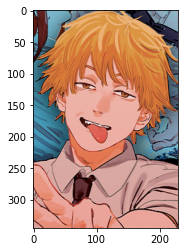

In [19]:
style_img = Image.open("../assets/character_images/character_images/130102.png")
plt.imshow(np.array(style_img))

In [25]:
content_img = Image.open("../assets/character_images/character_images/profile.png")
# plt.imshow(np.array(content_img))

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [24]:
print(np.array(style_img).shape)
print(np.array(content_img).shape)

(345, 230, 4)
(326, 236, 4)


In [ ]:
transform_steps = transforms.Compose([transforms.Resize(320, 230),transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = transform_steps(image).unsqueeze(0)
    return image.to(device, torch.float)


In [27]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super().__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super().__init__()
        self.target = self._gram_mat(target_feature).detach()

    def _gram_mat(input):
        _, c, h, w = input.size()
        input_features = tensor.view(c, h * w)
        gram = torch.mm(input_features, input_features.t())
        return gram

    def forward(self, input):
        G = self._gram_mat(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [28]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/dy0904k/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [29]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std